# Homework 2 - Exercise 4

## Emma Parois

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv

### Loss function (or energy function) and its derivative

In [2]:
def loss_function(targets, outputs):
    return 1/2 * (targets - outputs)**2

In [3]:
def loss_function_prime(targets, outputs):
    return targets - outputs

### Fully conected layer

In [4]:
class FCLayer():
    def __init__(self, input_size, output_size, activation, activation_prime):
        self.weights = np.random.rand(output_size, input_size) - 0.5
        self.thresholds = np.random.rand(output_size, 1) - 0.5
        self.activation = activation
        self.activation_prime = activation_prime
        self.input = None
        self.output = None
    
    def local_field(self):
        return -self.thresholds + self.weights @ self.input

    def forward_propagation(self, input):
        self.input = input
        self.output = self.activation(self.local_field())
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        output_error = self.activation_prime(self.local_field()) * output_error
        input_error = self.weights.T @ output_error
        
        self.weights += learning_rate * output_error @ self.input.T
        self.thresholds -= learning_rate * output_error

        return input_error

### Perceptron to train

In [5]:
class Perceptron():
    def __init__(self):
        self.layers = []
        
    def add(self, layer):
        self.layers.append(layer)
        
    def predict(self, input_patterns):
        predictions = np.empty(0)
        
        for input_pattern in input_patterns:
            output = input_pattern.reshape(input_patterns.shape[1],1)
            for layer in self.layers:
                output = layer.forward_propagation(output)
            predictions = np.append(predictions, np.sign(output.flatten()), axis=0)
            
        return predictions.reshape(predictions.shape[0],1)
        
        
    def fit(self, input_patterns, targets, nb_epochs, learning_rate):
        loss_variation = np.empty(0)
        p = input_patterns.shape[0]
        for i in tqdm(range(nb_epochs)):
            output = input_patterns[i%p].reshape(input_patterns.shape[1],1)
            target = targets[i%p].reshape(1,1)

            for layer in self.layers:
                output = layer.forward_propagation(output)

            output_error = loss_function_prime(target, output)
            for layer in reversed(self.layers):
                output_error = layer.backward_propagation(output_error, learning_rate)

            if i%p == 0:
                loss_variation = np.append(loss_variation, [loss_function(targets, self.predict(input_patterns)).sum()], axis=0)

        return loss_variation

## Training

In [6]:
M1 = 10

In [7]:
M2 = 10

In [8]:
tanh = lambda x: np.tanh(x)

In [9]:
tanh_prime = lambda x: 1 - np.tanh(x)**2

In [10]:
x_train = np.genfromtxt("../data/training_set.csv", delimiter=",")
y_train = x_train[:, 2].reshape(x_train.shape[0],1)
x_train = np.delete(x_train, 2, 1)

In [11]:
perceptron = Perceptron()

In [12]:
perceptron.add(FCLayer(2, M1, tanh, tanh_prime))
perceptron.add(FCLayer(M1, M2, tanh, tanh_prime))
perceptron.add(FCLayer(M2, 1, tanh, tanh_prime))

In [13]:
loss_variation = perceptron.fit(x_train, y_train, 1000000, 0.02)

100%|██████████| 1000000/1000000 [01:01<00:00, 16236.34it/s]


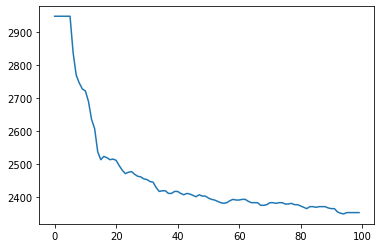

In [14]:
plt.plot(loss_variation)

## Validation

In [15]:
x_val = np.genfromtxt("../data/validation_set.csv", delimiter=",")

In [16]:
y_val = x_val[:,2].reshape(x_val.shape[0], 1)

In [17]:
x_val = np.delete(x_val, 2, 1)

In [18]:
y = perceptron.predict(x_val)

### Classification error

In [19]:
1/2 * np.mean(np.absolute(y - y_val)) * 100

11.799999999999999

## Write CSV

In [20]:
for file_num in range(3):
    file = open(f"../w{file_num+1}.csv", "w")
    writer = csv.writer(file)
    
    for row in perceptron.layers[file_num].weights:
        writer.writerow(row)
    
    file.close()
    
    file = open(f"../t{file_num+1}.csv", "w")
    writer = csv.writer(file)
    
    for row in perceptron.layers[file_num].thresholds:
        writer.writerow(row)
    
    file.close()